In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import joblib
from utils.embec_dens_localf_grace import EmbecDensLocalFGrace
from utils.reliability_visualizer import ReliabilityVisualizer

from utils.grace_classifier import GRACEClassifier

df_grace = pd.read_excel("dataset/data_validation.xlsx")

In [2]:

grace_classifier = GRACEClassifier()

def make_prediction(row):
    return grace_classifier.predict(
        age=row['Idade'],
        heart_rate=row['FC_admissao'],
        systolic_bp=row['PAS_admissao'],
        creatinine=row['Creatininaadmissao'],
        killip_class=row['Killip_maximo'],
        cardiac_arrest=row['Killip_entrada'],
        st_deviation=row['STEMI'],
        elevated_markers=row['Troponin_admissao']
    )

df_grace['Predicted'] = df_grace.apply(make_prediction, axis=1)


y_true = df_grace['Morte']
y_pred = df_grace['Predicted']

confusion_matrix(y_true, y_pred)

#[TN FP]
#[FN TP]


array([[60, 34],
       [ 7, 36]])

# Pointwise Dens & Local

In [3]:
###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('lr_pipeline_classifier.pkl')   # TODO: Just to make the data scaling 
training_data = pd.read_excel("dataset/data_train.xlsx")

y_train = training_data['Morte']
X_train = training_data.drop(columns=['Morte'])

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [4]:
###########################################################
# Threshold and k_max: 3.5_compute_thresholds.ipynb
###########################################################
threshold= 0.08954895293389985
k_max= 9

In [5]:
###########################################################
# Initialize EmbecDensLocalFGrace
###########################################################
reliability_calculator = EmbecDensLocalFGrace(
    X_train_preprocessed=X_train_preprocessed,
    y_train=y_train.values,
    pipeline=pipeline,
    k_max=k_max,
    threshold=threshold,
    X_train=X_train
)

In [6]:
###########################################################
# Classification & Load and Test with Unseen Data
###########################################################
validation_data = pd.read_excel("dataset/data_validation.xlsx")

# first_250_instances = validation_data.iloc[:250]

results = []
# for _, instance in first_250_instances.iterrows():
for _, instance in validation_data.iterrows():
    true_label = instance["Morte"]
    instance_df = pd.DataFrame([instance.drop(labels=["Morte"])])
    instance_preprocessed = pipeline.named_steps['preprocessor'].transform(instance_df)[0]
    
    reliability_score = reliability_calculator.compute_reliability(new_instance_preprocess=instance_preprocessed, new_instance=instance_df)

    # With Grace:
    new_data_row = instance_df.iloc[0]  # Extract the first (and only) row
    predicted_label = grace_classifier.predict(
                        age=new_data_row['Idade'],
                        heart_rate=new_data_row['FC_admissao'],
                        systolic_bp=new_data_row['PAS_admissao'],
                        creatinine=new_data_row['Creatininaadmissao'],
                        killip_class=new_data_row['Killip_maximo'],
                        cardiac_arrest=new_data_row['Killip_entrada'],
                        st_deviation=new_data_row['STEMI'],
                        elevated_markers=new_data_row['Troponin_admissao']
                    )
    # predicted_label = pipeline.named_steps["classifier"].predict([instance_preprocessed])[0]
    
    results.append({
        "true_label": true_label,
        "predicted_label": predicted_label,
        "reliability_score": reliability_score
    })

results_df = pd.DataFrame(results)


In [7]:
print(results)

[{'true_label': np.float64(0.0), 'predicted_label': 0, 'reliability_score': np.float64(0.0)}, {'true_label': np.float64(0.0), 'predicted_label': 0, 'reliability_score': np.float64(0.1111111111111111)}, {'true_label': np.float64(0.0), 'predicted_label': 1, 'reliability_score': np.float64(0.0)}, {'true_label': np.float64(0.0), 'predicted_label': 0, 'reliability_score': np.float64(0.8888888888888888)}, {'true_label': np.float64(1.0), 'predicted_label': 0, 'reliability_score': np.float64(0.6666666666666666)}, {'true_label': np.float64(1.0), 'predicted_label': 0, 'reliability_score': np.float64(0.345679012345679)}, {'true_label': np.float64(0.0), 'predicted_label': 0, 'reliability_score': np.float64(0.0)}, {'true_label': np.float64(1.0), 'predicted_label': 1, 'reliability_score': np.float64(0.0325)}, {'true_label': np.float64(0.0), 'predicted_label': 0, 'reliability_score': np.float64(0.2222222222222222)}, {'true_label': np.float64(1.0), 'predicted_label': 1, 'reliability_score': np.float64

In [8]:
from sklearn.metrics import confusion_matrix
# Extract true and predicted labels from the results DataFrame
y_true_after = results_df['true_label']
y_pred_after = results_df['predicted_label']

# Calculate confusion matrix
confusion_matrix(y_true, y_pred)
#[TN FP]
#[FN TP]

array([[60, 34],
       [ 7, 36]])

In [9]:
np.array_equal(y_true, y_true_after)

True

In [10]:
np.array_equal(y_pred, y_pred_after)

True

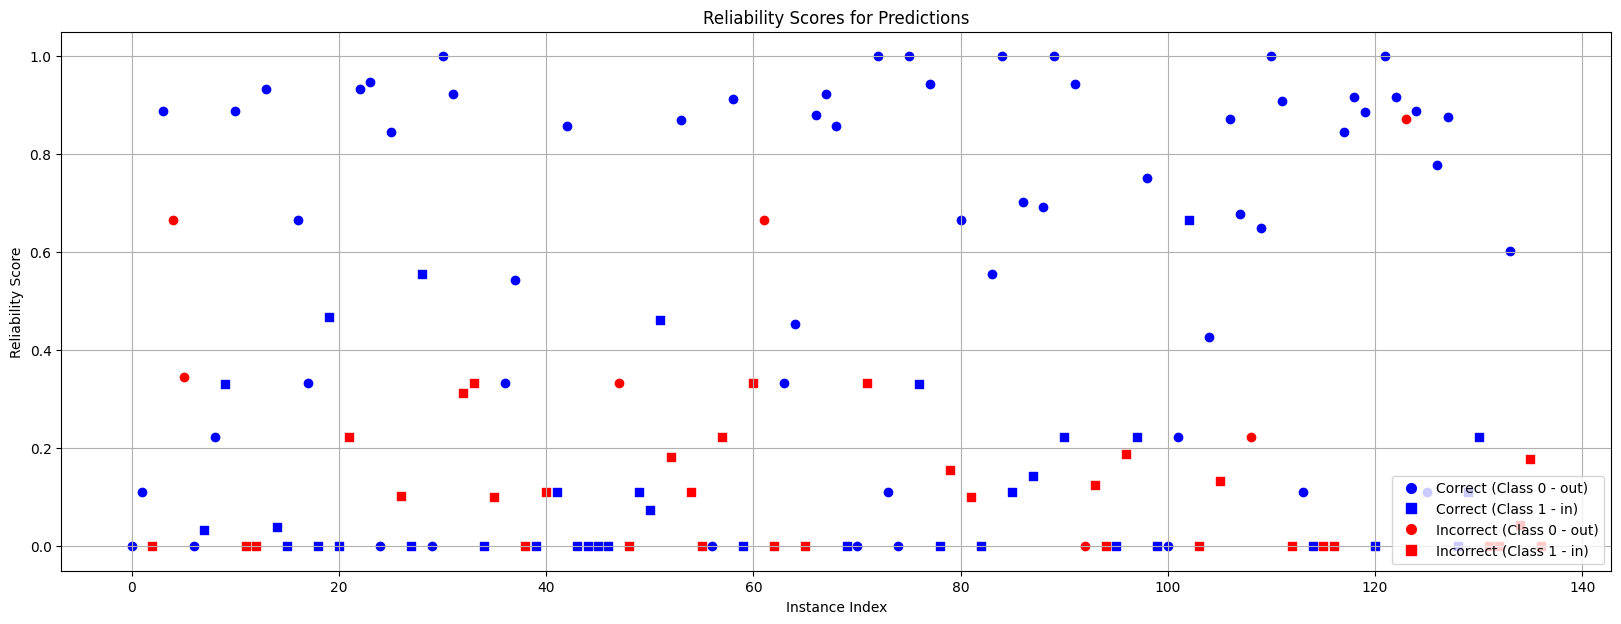

In [11]:
###########################################################
# Results
###########################################################
visualizer = ReliabilityVisualizer(results_df=results_df)

visualizer.plot_reliability_scores((20,7))

In [12]:
reliability_table_df = visualizer.get_reliability_table_5()

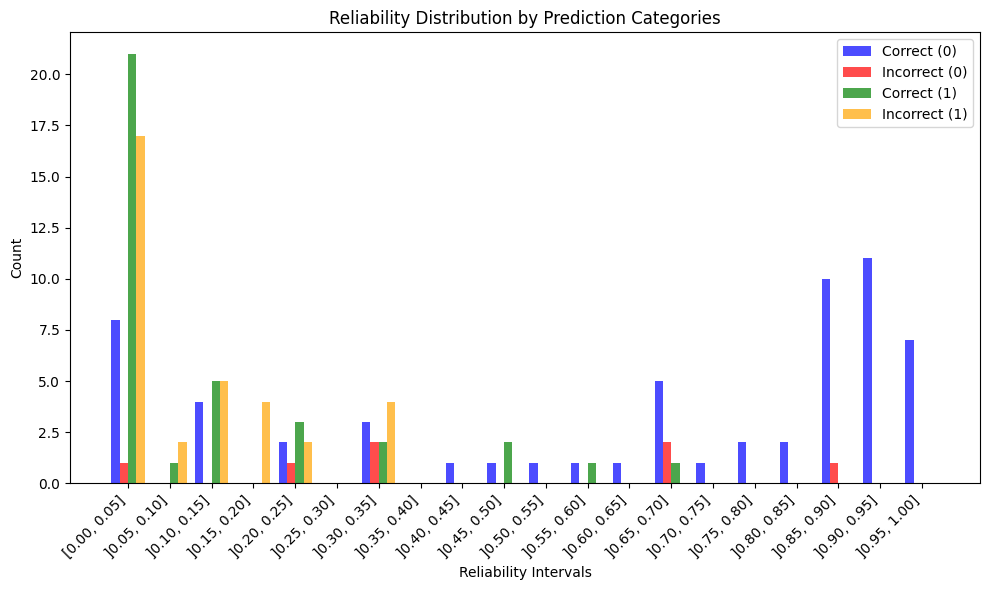

In [13]:
visualizer.plot_table_graph(reliability_table_df)

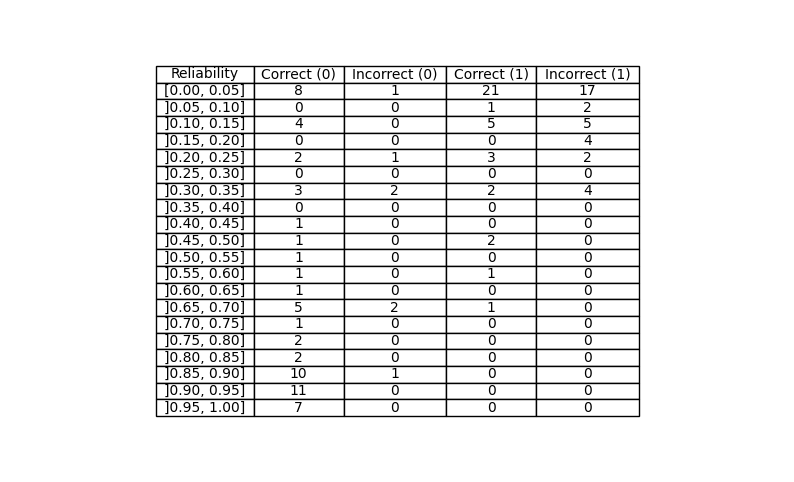

In [14]:
visualizer.plot_table_image(reliability_table_df)

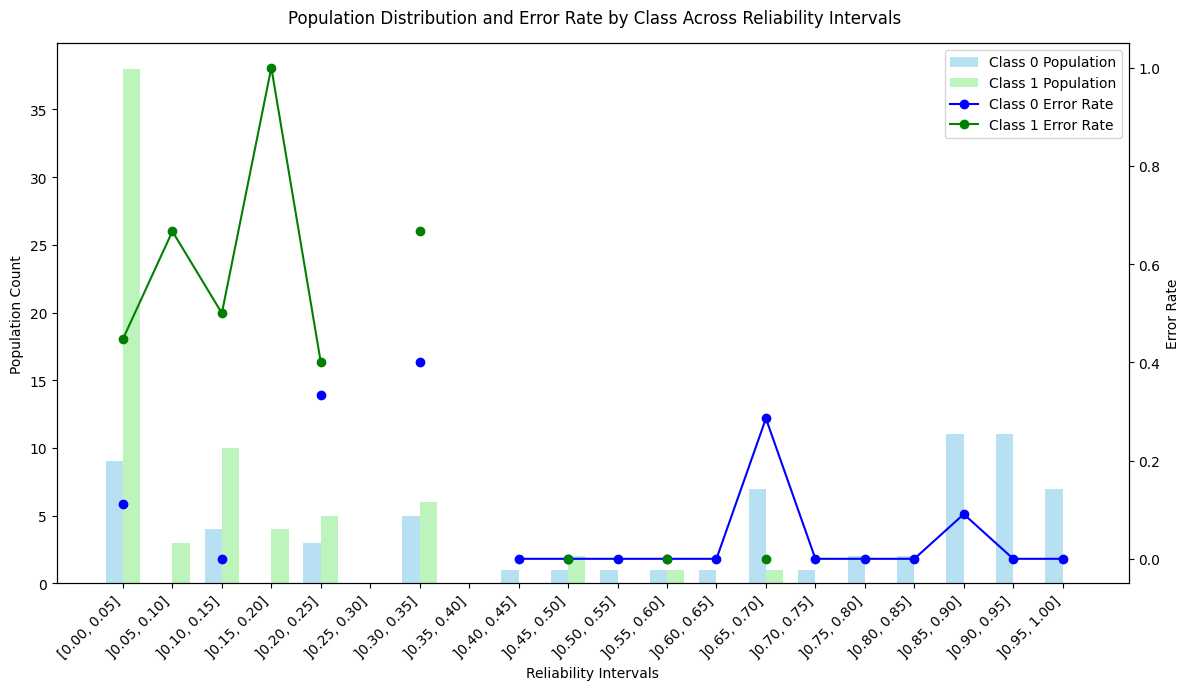

In [15]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [16]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]            8              1           22             19
1  ]0.10, 0.20]            4              0            5              9
2  ]0.20, 0.30]            2              1            3              2
3  ]0.30, 0.40]            3              2            2              4
4  ]0.40, 0.50]            2              0            2              0
5  ]0.50, 0.60]            2              0            1              0
6  ]0.60, 0.70]            6              2            1              0
7  ]0.70, 0.80]            3              0            0              0
8  ]0.80, 0.90]           12              1            0              0
9  ]0.90, 1.00]           18              0            0              0


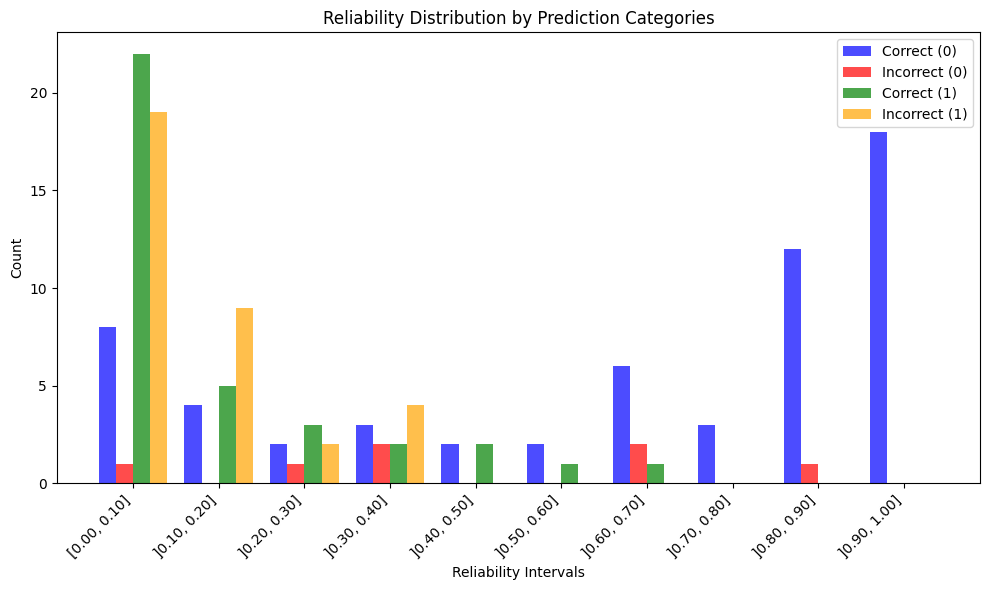

In [17]:
visualizer.plot_table_graph(reliability_table_10_df)

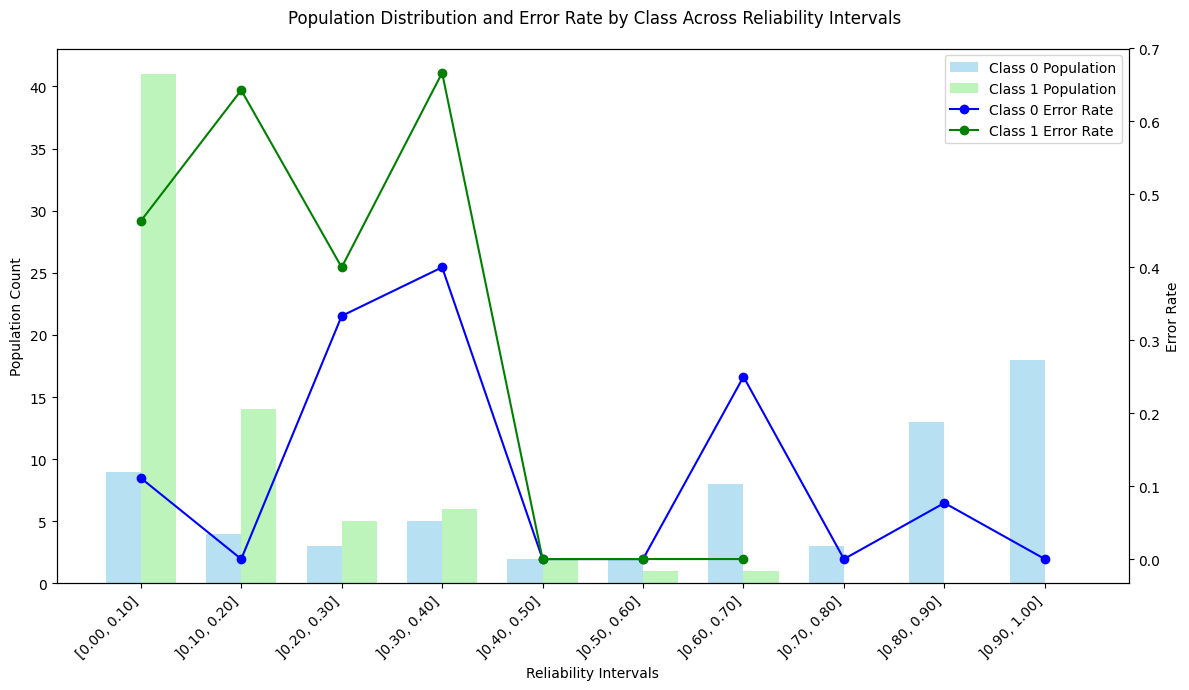

In [18]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           0.000000        (-0.001, 0.1]
1           0.111111           (0.1, 0.2]
2           0.000000        (-0.001, 0.1]
3           0.888889           (0.8, 0.9]
4           0.666667           (0.6, 0.7]
5           0.345679           (0.3, 0.4]
6           0.000000        (-0.001, 0.1]
7           0.032500        (-0.001, 0.1]
8           0.222222           (0.2, 0.3]
9           0.330579           (0.3, 0.4]


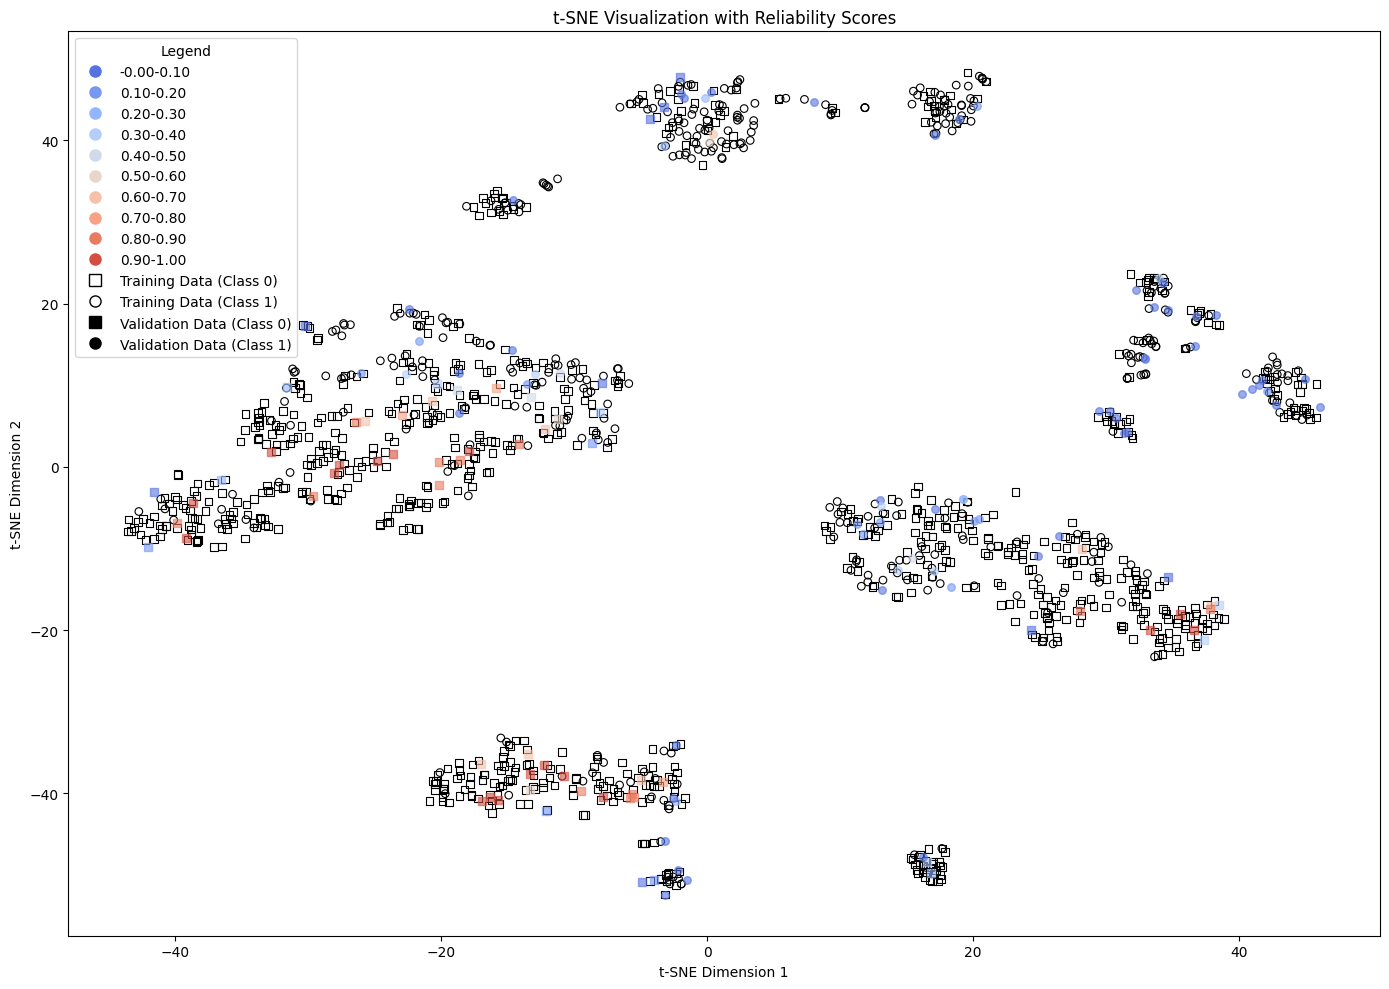

In [19]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)